# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [42]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools

In [43]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [44]:
kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.363e+00                    4.470e-01    3.049
INFO     1     5.393e-01 (0.396) [0.396]    2.739e-01    1.977 (0.647)
INFO     2     2.250e-01 (0.418) [0.407]    2.075e-01    1.098 (0.554)
INFO     3     1.019e-01 (0.453) [0.422]    1.770e-01    0.592 (0.536)
INFO     4     5.285e-02 (0.518) [0.444]    1.592e-01    0.347 (0.581)
INFO     5     3.171e-02 (0.599) [0.472]    1.475e-01    0.229 (0.652)
INFO     6     2.152e-02 (0.677) [0.501]    1.389e-01    0.168 (0.724)
INFO     7     1.591e-02 (0.738) [0.530]    1.322e-01    0.132 (0.780)
INFO     8     1.245e-02 (0.782) [0.556]    1.268e-01    0.109 (0.819)
INFO     9     1.015e-02 (0.815) [0.580]    1.224e-01    0.092 (0.848)
INFO     10    8.505e-03 (0.839) [0.602]    1.185e-01    0.080 (0.869)
INFO     11    7.289e-03 (0.858) [0.622]    1.152e-01    0.070 (0.885)
INFO     12    6.357e-03 (0.873) [0.640]    1.123e-01    0.063 (0.898)
INFO 

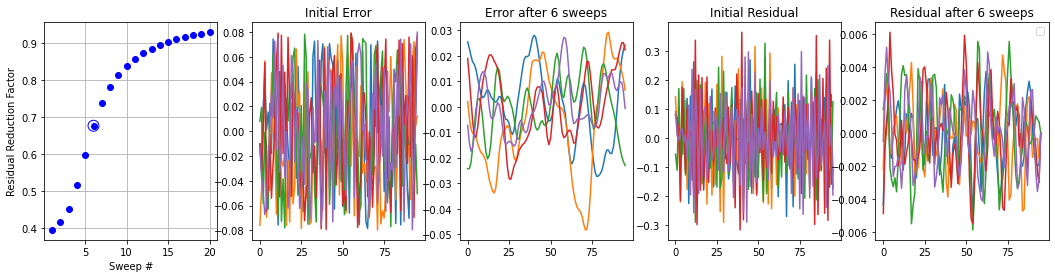

In [45]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

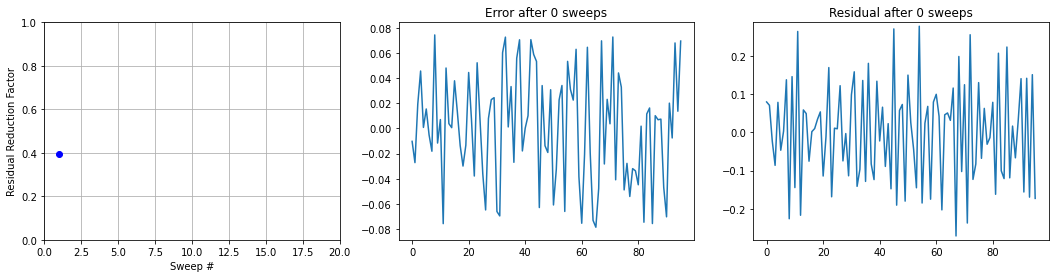

In [46]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
#animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [47]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
print("kh", kh)

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

kh 0.5233853805513012


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     7.015e-01 (0.566) [0.566]    3.514e-01    2.002 (0.721)
INFO     2     4.137e-01 (0.590) [0.578]    3.063e-01    1.357 (0.678)
INFO     3     2.586e-01 (0.626) [0.594]    2.831e-01    0.919 (0.677)
INFO     4     1.786e-01 (0.691) [0.617]    2.696e-01    0.667 (0.726)
INFO     5     1.359e-01 (0.761) [0.643]    2.603e-01    0.526 (0.788)
INFO     6     1.114e-01 (0.819) [0.670]    2.533e-01    0.442 (0.842)
INFO     7     9.643e-02 (0.864) [0.695]    2.475e-01    0.391 (0.885)
INFO     8     8.616e-02 (0.893) [0.717]    2.426e-01    0.357 (0.911)
INFO     9     7.854e-02 (0.911) [0.736]    2.382e-01    0.331 (0.928)
INFO     10    7.285e-02 (0.927) [0.753]    2.343e-01    0.312 (0.943)
INFO     11    6.842e-02 (0.939) [0.769]    2.307e-01    0.297 (0.953)
INFO     12    6.482e-02 (0.947) [0.782]    2.274e-01    0.286 (0.961)
INFO 

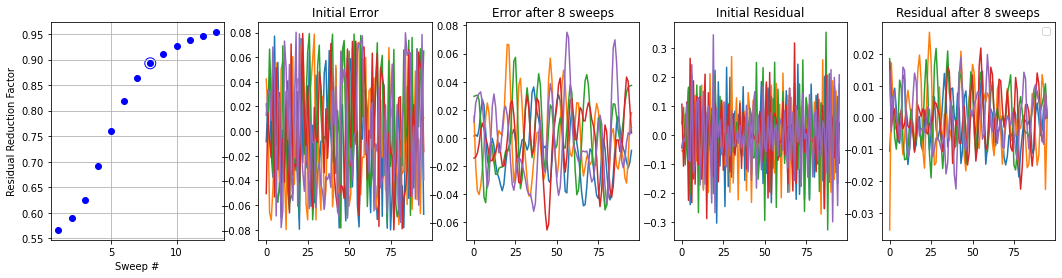

In [48]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

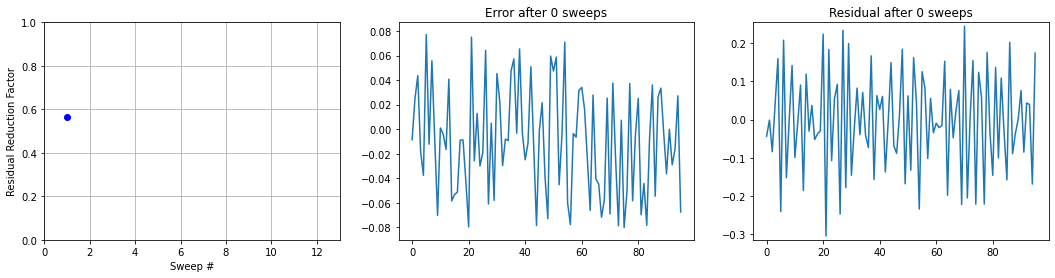

In [49]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
#animation.write_videofile("kaczmarz_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [50]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.118


### Coarsening: Fixed (4/2)

In [51]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

nu  30 s [1.    0.624 0.092 0.013] Energy error [0.533 0.078 0.011 0.   ]
INFO     Mock cycle conv [0.597 0.328 0.199 0.153 0.149 0.126 0.087 0.072 0.069 0.064 0.062]


array([[-0.409, -0.538, -0.565, -0.473],
       [-0.7  , -0.265,  0.243,  0.617]])

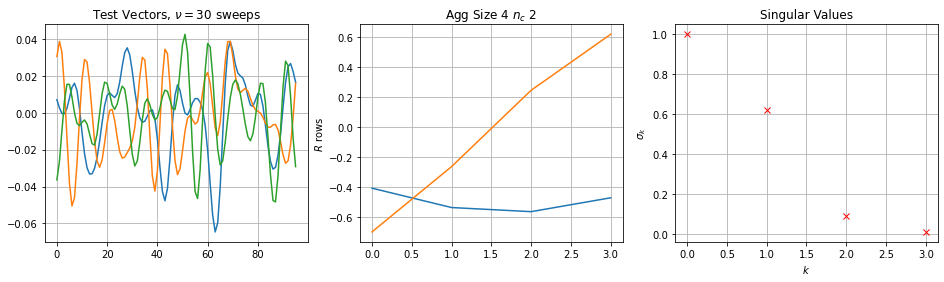

In [52]:
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 30, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.4345,-0.5721,-0.5620,-0.4099,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6537,0.2360,-0.2553,-0.6722,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4345,-0.5721,-0.5620,-0.4099,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6537,0.2360,-0.2553,-0.6722,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4345,-0.5721


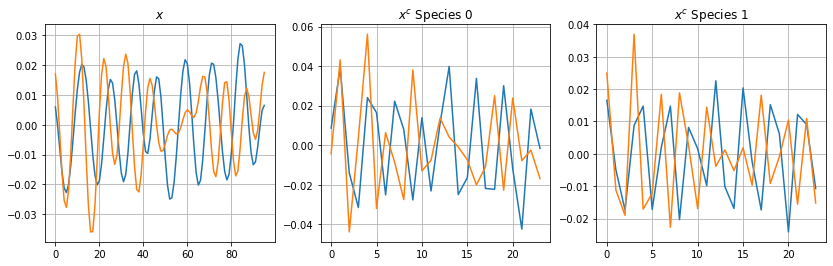

In [53]:
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with 100 relaxations on the coarse level.

In [54]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = 100 # -1
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.116


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.6079,0.3290,0.1976,0.1387,0.1436,0.1276,0.0858,0.0666,0.0581,0.0517,0.0492
P^T A P caliber 2,1.2000,0.0000,0.5119,0.4254,0.4191,0.4308,0.4298,0.4410,0.4433,0.4402,0.4353,0.4440,0.4430
P^T A P caliber 3,1.4000,0.0000,0.6004,0.3490,0.3278,0.3145,0.3022,0.2708,0.2978,0.2693,0.2996,0.2995,0.3006
P^T A P caliber 4,2.0000,0.0000,0.6033,0.3409,0.2071,0.1365,0.1496,0.1343,0.1175,0.1174,0.1180,0.1280,0.1283
Q A P caliber 4,1.2000,0.0000,1.1998,0.5711,0.3751,0.1895,0.2166,0.1684,0.1307,0.0947,0.0655,0.0416,0.0437
R A P caliber 4,1.2000,0.0040,1.1956,0.5823,0.3779,0.1932,0.2030,0.1664,0.1297,0.0919,0.0670,0.0561,0.0522


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [55]:
# for use_r_as_restriction in (False, True):

#     print("R*A*P" if use_r_as_restriction else "P^T*A*P")
#     for caliber in calibers:
#         p = p_caliber[caliber]
#         ml = hm.repetitive.locality.create_two_level_hierarchy(
#             kh, discretization, n, r, p, r if use_r_as_restriction else p.T, aggregate_size, num_components)
#         ac = ml[1].a
#         print("caliber {} P".format(caliber))
#         display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
#         print("A^1")
#         display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))

In [56]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_caliber[4]

### Solving $Ax = b$ - Convergence History

#### $R A P$

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      1.882e+01           2.243           8.390
INFO     1      5.038e+00  (0.268)  2.244  (1.000)  2.245
INFO     2      1.474e+00  (0.293)  1.232  (0.549)  1.196
INFO     3      6.079e-01  (0.413)  0.581  (0.472)  1.046
INFO     4      2.388e-01  (0.393)  0.233  (0.400)  1.027
INFO     5      1.022e-01  (0.428)  0.100  (0.429)  1.024
INFO     6      4.266e-02  (0.417)  0.042  (0.418)  1.023
INFO     7      1.798e-02  (0.421)  0.018  (0.421)  1.023
INFO     8      7.524e-03  (0.419)  0.007  (0.419)  1.023
INFO     9      3.204e-03  (0.426)  0.003  (0.426)  1.023
INFO     10     1.380e-03  (0.431)  0.001  (0.431)  1.023
INFO     11     5.998e-04  (0.435)  0.001  (0.435)  1.023
INFO     12     2.607e-04  (0.435)  0.000  (0.435)  1.023
INFO     13     1.131e-04  (0.434)  0.000  (0.434)  1.023
INFO     14     4.885e-05  (0.432)  0.000  (0.432)  1.023
INFO     15     2.094e-05  (0.429)  0.000  (0.429)  1.023
INFO     16  

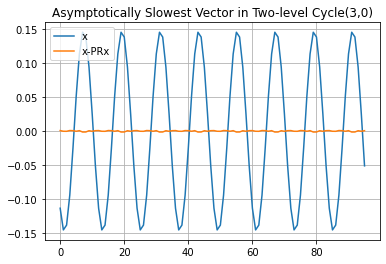

In [57]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, r, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, 3, nu_post=0, nu_coarsest=100, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [58]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.     0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]


In [59]:
pd.set_option("display.precision", 8)
pd.DataFrame(m0[0].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,-0.0833,1.3333,-2.2261,1.3333,-0.0833,0.0000
1,0.0000,-0.0833,1.3333,-2.2261,1.3333,-0.0833


In [60]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.1483,0.1625,-0.0324,-0.0043,0.1469,-0.1698
1,-0.1718,-0.1445,-0.0083,-0.6083,0.1625,-0.1463


In [61]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0040,-0.0014,0.0020,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0040,0.0000,-0.0001,-0.0018,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0014,0.0001,0.0000,0.0040,-0.0014,0.0020,0.0000,0.0000,0.0000,0.0000
3,-0.0020,0.0018,-0.0040,0.0000,-0.0001,-0.0018,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0014,0.0001,0.0000,0.0040,-0.0014,0.0020,0.0000,0.0000
5,0.0000,0.0000,-0.0020,0.0018,-0.0040,0.0000,-0.0001,-0.0018,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0014,0.0001,0.0000,0.0040,-0.0014,0.0020
7,0.0000,0.0000,0.0000,0.0000,-0.0020,0.0018,-0.0040,0.0000,-0.0001,-0.0018
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0014,0.0001,0.0000,0.0040
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0020,0.0018,-0.0040,0.0000


## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [62]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [63]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.412e-01                    4.467e-01    0.542
INFO     1     8.969e-02 (0.375) [0.375]    2.645e-01    0.340 (0.633)
INFO     2     4.695e-02 (0.526) [0.443]    2.009e-01    0.240 (0.702)
INFO     3     2.918e-02 (0.617) [0.497]    1.727e-01    0.171 (0.721)
INFO     4     2.165e-02 (0.741) [0.549]    1.557e-01    0.142 (0.826)
INFO     5     1.692e-02 (0.776) [0.590]    1.444e-01    0.119 (0.839)
INFO     6     1.405e-02 (0.826) [0.624]    1.364e-01    0.104 (0.876)
INFO     7     1.197e-02 (0.849) [0.653]    1.303e-01    0.093 (0.890)
INFO     8     1.041e-02 (0.868) [0.677]    1.256e-01    0.084 (0.902)
INFO     9     9.183e-03 (0.880) [0.697]    1.218e-01    0.076 (0.909)
INFO     10    8.191e-03 (0.890) [0.714]    1.186e-01    0.070 (0.915)
INFO     11    7.376e-03 (0.899) [0.730]    1.160e-01    0.065 (0.920)
INFO     12    6.700e-03 (0.906) [0.743]    1.138e-01    0.060 (0.925)
INFO 

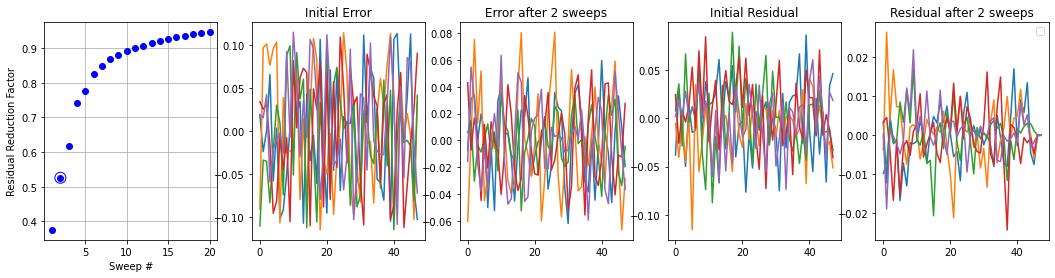

In [64]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

nu 100 s [1.    0.801 0.006 0.001] Energy error [0.625 0.005 0.001 0.   ]
INFO     Mock cycle conv [0.328 0.21  0.138 0.113 0.102 0.085 0.064 0.057 0.036 0.027 0.03 ]


array([[ 0.663, -0.246, -0.667, -0.234],
       [ 0.485,  0.515,  0.475, -0.524]])

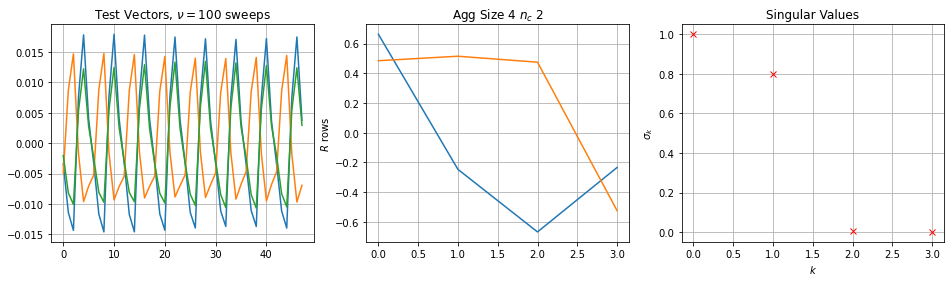

In [65]:
# #PCs revealed by relaxed vectors of increasing smoothness.
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [66]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1483,0.1625,-0.0324,-0.0043,0.1469,-0.1698
1,-0.1718,-0.1445,-0.0083,-0.6083,0.1625,-0.1463


In [67]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.001


[1.    0.834 0.003 0.   ]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,0.6667,-0.2424,-0.6634,-0.2380,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.4791,-0.5172,-0.4798,0.5223,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.6667,-0.2424,-0.6634,-0.2380,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.4791,-0.5172,-0.4798,0.5223,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6667,-0.2424


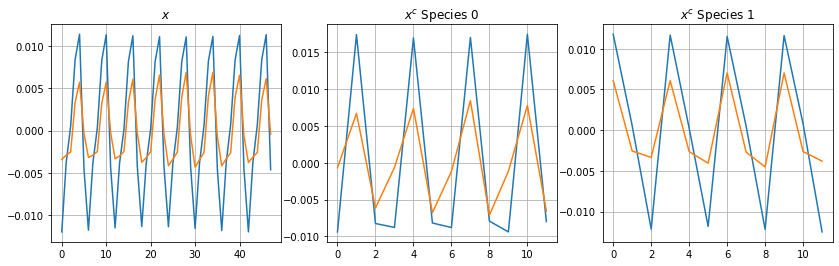

In [68]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with an exact solver on the coarse level.

In [69]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 100
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.002


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.3451,0.1982,0.1349,0.1199,0.1028,0.0841,0.0698,0.0544,0.0457,0.0334,0.0291
P^T A P caliber 2,1.0000,0.0018,14.2864,8.9435,8.1574,6.7145,5.6502,4.7194,3.9353,3.2729,2.7150,2.2473,1.8560
P^T A P caliber 3,1.1667,0.0007,1.0860,0.7458,0.4162,0.2684,0.2313,0.1770,0.1500,0.1226,0.1144,0.1044,0.1011
P^T A P caliber 4,1.6667,0.0007,1.3843,0.6950,0.3411,0.1917,0.1024,0.0493,0.0377,0.0434,0.0332,0.0327,0.0271
Q A P caliber 4,1.0000,0.0000,2.9053,1.5006,0.3345,0.3767,0.3855,0.4005,0.4127,0.4206,0.4087,0.4153,0.4134
R A P caliber 4,1.0000,0.0277,1.9554,1.0611,0.2784,0.1022,0.0801,0.0512,0.0512,0.0337,0.0419,0.0362,0.0296


Now, calculate the rates with 100 relaxations at the coarse level.

In [70]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = 100
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.001


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.3430,0.2104,0.1324,0.0944,0.1011,0.0831,0.0693,0.0416,0.0404,0.0320,0.0282
P^T A P caliber 2,1.0000,0.0018,14.6912,9.1884,8.3801,6.8984,5.8027,4.8465,4.0409,3.3598,2.7870,2.3021,1.9054
P^T A P caliber 3,1.1667,0.0008,1.2463,0.8795,0.9983,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
P^T A P caliber 4,1.6667,0.0007,1.2451,0.9885,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001
Q A P caliber 4,1.0000,0.0000,3.4226,1.6292,1.0266,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
R A P caliber 4,1.0000,0.0398,1.9496,1.0439,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


### Solving $Ax = b$ - Convergence History
If we don't solve exactly at the coarsest level, the cycle stalls.

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      3.180e+00           0.593           5.358
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            4.5894e-01    7.9828e-01
INFO     0        relax 5            3.3760e-02    6.5361e-02
INFO     1        initial            3.6174e-02    7.2747e-02
INFO     1        relax 100          2.9916e-05    6.7741e-05
INFO     0        correction         2.3054e-02    3.8069e-02
INFO     1      1.597e-01  (0.050)  0.240  (0.404)  0.666
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            2.3054e-02    3.8069e-02
INFO     0        relax 5            1.9627e-03    3.3339e-03
INFO     1        initial            2.1487e-03    3.3658e-03
INFO     1        relax 1

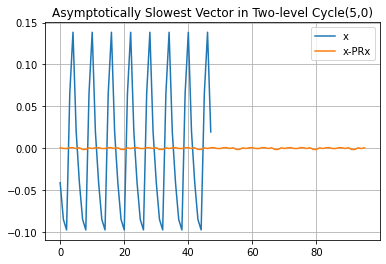

In [79]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5
p = p_caliber[4]  # P^T*A*P P high order

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, r, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1, nu_coarsest=100,
                                                    debug=True)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

### Level 2 relaxation shrinkage
Relaxation does converge.

Finest level 24
INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     5.311e-02                    4.469e-01    0.119
INFO     1     1.782e-02 (0.333) [0.333]    2.545e-01    0.070 (0.586)
INFO     2     9.043e-03 (0.523) [0.412]    1.848e-01    0.049 (0.717)
INFO     3     6.326e-03 (0.703) [0.491]    1.501e-01    0.044 (0.873)
INFO     4     4.340e-03 (0.681) [0.534]    1.295e-01    0.035 (0.800)
INFO     5     3.047e-03 (0.703) [0.564]    1.171e-01    0.029 (0.791)
INFO     6     2.187e-03 (0.720) [0.587]    1.095e-01    0.023 (0.784)
INFO     7     1.603e-03 (0.735) [0.606]    1.048e-01    0.018 (0.781)
INFO     8     1.191e-03 (0.744) [0.622]    1.019e-01    0.015 (0.777)
INFO     9     8.952e-04 (0.751) [0.635]    1.001e-01    0.012 (0.774)
INFO     10    6.788e-04 (0.757) [0.646]    9.899e-02    0.009 (0.773)
INFO     11    5.186e-04 (0.762) [0.656]    9.829e-02    0.007 (0.773)
INFO     12    3.989e-04 (0.767) [0.665]    9.787e-02    0.0

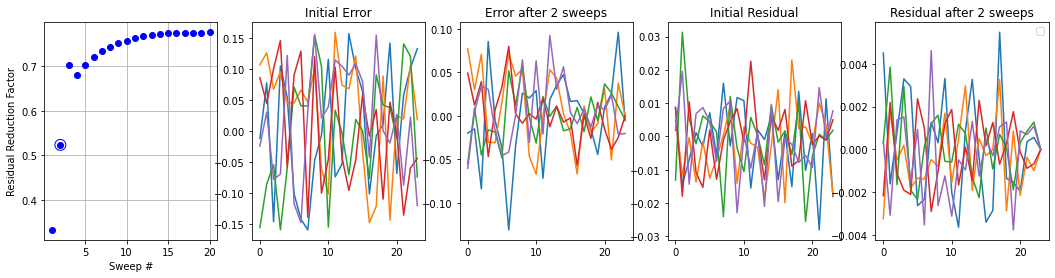

In [80]:
m2 = m1.sub_hierarchy(1)
print("Finest level", m2[0].size)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m2, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

In [81]:
pd.DataFrame(m1[1]._r.todense()[:2, :4])

,0,1,2,3
0,0.6667,-0.2424,-0.6634,-0.2380
1,-0.4791,-0.5172,-0.4798,0.5223


In [82]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12], lam[0])

0 lam [ 0.     0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166] 1.7713661225777997e-05
1 lam [ 0.     0.     0.013  0.013 -0.031 -0.031 -0.048  0.058  0.058  0.07   0.07  -0.073] 1.7551115283889817e-05


## 3-Level Method
With $Q A P$ coarsening at level $0$ and $R A P$ at leve1 1.

In [83]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(m0[0])
ml.add(m0[1])
ml.add(m1[1])

In [85]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(ml, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
#plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# # y -= y.mean() # Remove zero component.
# # e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.025e+01           2.718           7.449
INFO     1      1.029e+00  (0.051)  0.011  (0.004)  95.459
INFO     2      1.319e-01  (0.128)  0.002  (0.152)  80.281
INFO     3      1.812e-02  (0.137)  0.000  (0.133)  82.864
INFO     4      2.745e-03  (0.152)  0.000  (0.152)  82.522
INFO     5      4.354e-04  (0.159)  0.000  (0.159)  82.544
INFO     6      8.074e-05  (0.185)  0.000  (0.185)  82.548
INFO     7      1.622e-05  (0.201)  0.000  (0.201)  82.546
INFO     8      3.161e-06  (0.195)  0.000  (0.195)  82.547
INFO     9      5.686e-07  (0.180)  0.000  (0.180)  82.547
INFO     10     9.589e-08  (0.169)  0.000  (0.169)  82.547
INFO     11     1.652e-08  (0.172)  0.000  (0.172)  82.547
INFO     12     3.175e-09  (0.192)  0.000  (0.192)  82.547
INFO     13     6.407e-10  (0.202)  0.000  (0.202)  82.547
INFO     14     1.302e-10  (0.203)  0.000  (0.203)  82.547
INFO     15     1.972e-11  (0.152)  0.000  (0.152)  82.54

In [86]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.     0.     0.065  0.065 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]
2 lam [ 0.     0.     0.022  0.022 -0.026 -0.026 -0.046  0.055  0.055 -0.061 -0.061  0.077]


In [87]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

## What are the Coarse Variables?
Given level $l$ and some point $i$,  we look at $P^l P^{l-1} ... P^1 e^l_i$ wheer $e^l_i$ is the $i$th unit vector. There are two species ($i, i+1$) in our setup (4/2 coarsening at all levels). The following matix is level x species.

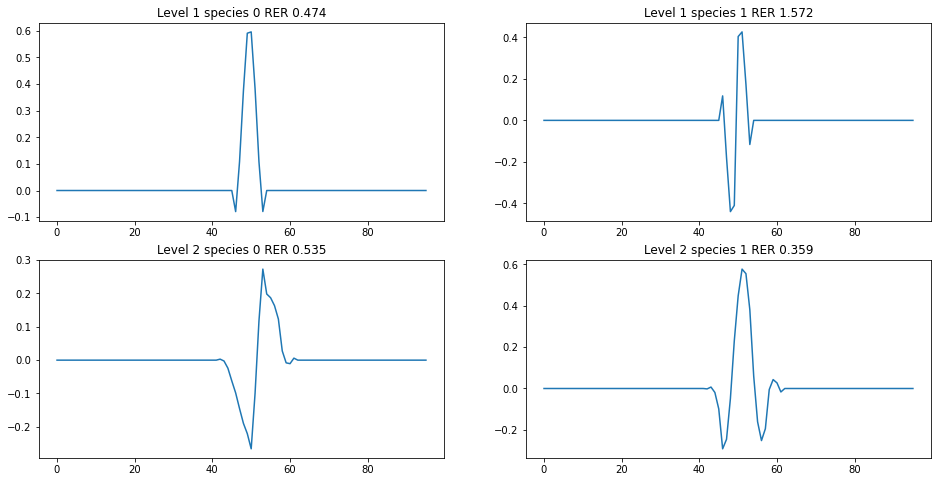

In [98]:
fig, axs = plt.subplots(len(ml) - 1, num_components, figsize=(16, 8))

for l in range(1, len(ml)):
    m = ml[l].size
    i = m // 2
    for col, j in enumerate(range(i, i + num_components)):
        u = np.zeros((m,))
        u[j] = 1
        for ll in range(l, 0, -1):
            u = ml[ll]._p.dot(u)
        axs[l - 1, col].set_title("Level {} species {} RER {:.3f}".format(l, col, norm(ml[0].operator(u)) / norm(u)))
        axs[l - 1, col].plot(u);